## 1. 导入相关库

In [126]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import time
import statsmodels.api as sm
import pickle
from statsmodels.datasets import co2
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, date

### 1.1 Python Matplotlib pyplot 支持中文标题

In [127]:
plt.rcParams["font.family"] = ["sans-serif"]
plt.rcParams["font.sans-serif"] = ['SimHei']

### 2.1.使用 forward fill填补缺失值

In [128]:
ffill_df = pd.read_csv('Average_cost_of_fossil_fuels_for_electricity_generation_natural_gas_California_electric_power_(total)_monthly.csv');
ffill_df['填补缺失值后'] = ffill_df['value'].ffill()
ffill_df.head(20)

,Month,value,填补缺失值后
0,Dec-21,6.83,6.83
1,Nov-21,6.72,6.72
2,Oct-21,6.88,6.88
3,Sep-21,6.74,6.74
4,Aug-21,5.93,5.93
5,Jul-21,5.74,5.74
6,Jun-21,4.74,4.74
7,May-21,NaN,4.74
8,Apr-21,3.78,3.78
9,Mar-21,3.94,3.94


### 2.2.使用moving average填补缺失值

In [129]:
moving_average_df = pd.read_csv('Average_cost_of_fossil_fuels_for_electricity_generation_natural_gas_California_electric_power_(total)_monthly.csv');
moving_average_df['填补缺失值后'] = np.where(moving_average_df['value'].isnull(),
                             moving_average_df['value'].shift(1).rolling(3,min_periods=1).mean(),
                             moving_average_df['value'])
moving_average_df.head(20)

,Month,value,填补缺失值后
0,Dec-21,6.83,6.830000
1,Nov-21,6.72,6.720000
2,Oct-21,6.88,6.880000
3,Sep-21,6.74,6.740000
4,Aug-21,5.93,5.930000
5,Jul-21,5.74,5.740000
6,Jun-21,4.74,4.740000
7,May-21,NaN,5.470000
8,Apr-21,3.78,3.780000
9,Mar-21,3.94,3.940000


### 2.3. 使用interpolation填补缺失值

In [130]:
linear_interpolation_df = pd.read_csv('Average_cost_of_fossil_fuels_for_electricity_generation_natural_gas_California_electric_power_(total)_monthly.csv');
linear_interpolation_df['填补缺失值后'] = linear_interpolation_df['value'].interpolate(method='linear')
linear_interpolation_df.head(20)

,Month,value,填补缺失值后
0,Dec-21,6.83,6.83
1,Nov-21,6.72,6.72
2,Oct-21,6.88,6.88
3,Sep-21,6.74,6.74
4,Aug-21,5.93,5.93
5,Jul-21,5.74,5.74
6,Jun-21,4.74,4.74
7,May-21,NaN,4.26
8,Apr-21,3.78,3.78
9,Mar-21,3.94,3.94


# 3. 平稳性检验

In [131]:
# 转换Month格式
linear_interpolation_df['月份'] = linear_interpolation_df['Month'].map(lambda dt: datetime.strptime(dt,'%b-%y'))
linear_interpolation_df.head()

,Month,value,填补缺失值后,月份
0,Dec-21,6.83,6.83,2021-12-01
1,Nov-21,6.72,6.72,2021-11-01
2,Oct-21,6.88,6.88,2021-10-01
3,Sep-21,6.74,6.74,2021-09-01
4,Aug-21,5.93,5.93,2021-08-01


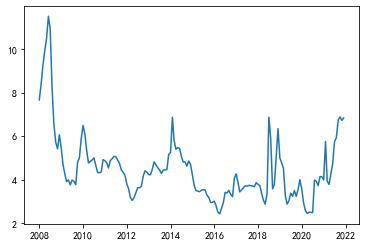

In [132]:
plt.plot(linear_interpolation_df['月份'],linear_interpolation_df['填补缺失值后'])
plt.show()

### adfuller平稳性检验

In [133]:
linear_interpolation_data_for_adfuller = linear_interpolation_df[['填补缺失值后']]
adfuller结果 = adfuller(linear_interpolation_data_for_adfuller)
print('p value:', adfuller结果[1])
if adfuller结果[1] > 0.05:
    print('p value大于0.05，所以序列非平稳')
else:
    print('p value小于等于0.05，所以序列平稳')

p value: 0.10403123073706794
p value大于0.05，所以序列非平稳


### 进行差分

In [134]:
# # 一阶差分
data_diff1 = linear_interpolation_data_for_adfuller.diff()
data_diff1[np.isnan(data_diff1)] = 0
# # 如果需要，则继续 二阶差分
# data_diff2 = data_diff1.diff()
# data_diff2[np.isnan(data_diff2)] = 0
 
# 如果需要，则继续季节差分
# data_diff = linear_interpolation_data_for_adfuller.diff(12).dropna()
 
# ADF检验
adfuller结果 = adfuller(data_diff1)
print('p value:', adfuller结果[1])
if adfuller结果[1] > 0.05:
    print('p value大于0.05，所以序列非平稳')
else:
    print('p value小于等于0.05，所以序列平稳')

p value: 9.43153641303655e-18
p value小于等于0.05，所以序列平稳


# 